<a href="https://colab.research.google.com/github/Agalea96/lightgbm/blob/main/Copy_of_Lightgbm_implementation_ethics_gridsearch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Install SHAP, the module to make explainable AI.**

In [ ]:
%pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 8.8 MB/s eta 0:00:00


**Step 2: Import all modules needed**

In [ ]:
from pickle import TRUE
# importing all needed libraries
import hyperopt
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import lightgbm
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)
# input dataset
df_train = pd.read_csv('/content/Traffic_Violation_Clean.csv', low_memory=False)


**Step 3 encode labels from string to numbers**

In [ ]:
label_encoder = LabelEncoder()
def enc_labels(label):
    return label_encoder.fit_transform(df_train[label])
df_train.drop(columns=['Year', 'Year Stopped', 'DateTime Of Stop', 'Geolocation'])
cat_features=df_train.select_dtypes(include=['object', 'int32']).columns
for x in cat_features:
    df_train['encoded_' + x] = enc_labels(x)

**Step 4: Filter the columns with a boolean, integer or float data structure**

In [ ]:
filtered_columns=df_train.select_dtypes(include=['bool','int32','int64','float64'])

**Step 5: Set up Lables and Features**

In [ ]:
# selecting all columns that are not the 'ID code' and 'target' columns
var_columns = [c for c in filtered_columns.columns if c not in ['encoded_Violation Type']]
print(var_columns)

# defining inputs as X labels as Y
X = filtered_columns.loc[:,var_columns]
Y = filtered_columns.loc[:,'encoded_Violation Type']

# splitting training data and labels into training data and labels and validation data and labels
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y,test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape

['Accident', 'Belts', 'Personal Injury', 'Property Damage', 'Fatal', 'Commercial License', 'HAZMAT', 'Commercial Vehicle', 'Alcohol', 'Work Zone', 'Search Conducted', 'Year', 'Contributed To Accident', 'Year Stopped', 'Number Of Offences', 'encoded_SubAgency', 'encoded_Location', 'encoded_Search Outcome', 'encoded_Search Reason For Stop', 'encoded_State', 'encoded_VehicleType', 'encoded_Make', 'encoded_Color', 'encoded_Race', 'encoded_Gender', 'encoded_Driver City', 'encoded_Driver State', 'encoded_DL State', 'encoded_Arrest Type', 'encoded_Geolocation', 'encoded_DateTime Of Stop', 'encoded_Road Signs And Markings', 'encoded_Disobedience', 'encoded_Invalid Documentation', 'encoded_Mobile Phone', 'encoded_Speeding', 'encoded_Negligent Driving', 'encoded_Vehicle Safety And Standards']


((112874, 38), (28219, 38), (28219, 38), (112874,), (28219,), (28219,))

**Step 6: Set up KFold with 5 splits on the training data.**

Kfold is a method used to split the data into many groups, each time setting one of the groups as a test set, whilst the others are set to be training sets.  This is repeated untill all groups are used as test sets for one time.

This is done to maximise training and validation without compromising the validitiy of the test set.

In [ ]:
gkf=KFold(n_splits=5,shuffle=True,random_state=42).split(X_train, Y_train)

**Step 7: Set up Training and Validation datasets in the format used in lightGBM**

In [ ]:
# setting up training and validation data so that they can be read by the lightgbm module
train_data = lightgbm.Dataset(X_train, label = Y_train)
valid_data = lightgbm.Dataset(X_valid, label = Y_valid)

**Step 8: Setting up metrics for evaluation for the gridsearch minimization function**

This was done by exploiting the SHAP value metric function which gives the importance of certain features to an AI model (in this case the LightGBM multiclass classifier).  This shall be done in an effort to reduce the importance of these two columns for the required prediction, resultin in more ethically correct AI based prediticions.

In [ ]:
# Define a function to calculate the minimum SHAP value
def shap_columns_metric(y_true, y_pred):
    # Calculate SHAP values for the model predictions
    explainer = shap.Explainer(model_lgbm)
    shap_values = explainer.shap_values(X_train)

    # Get the column indices for the two columns you want to minimize SHAP values for
    encoded_Race_index = X_train.columns.get_loc("encoded_Race")
    encoded_Gender_index = X_train.columns.get_loc("encoded_Gender")

    # Calculate the sum of the absolute SHAP values for the two columns
    shap_values_columns = abs(shap_values[:, [encoded_Race_index, encoded_Gender_index]]).sum(axis=1)
    total_shap_columns = -shap_values_columns.sum()
    return total_shap_columns

**Step 9: Set up the Parameter grid for the gridsearch algorithm.**

In this step, we are not only defining the hyperparameters needed to run the AI Predictions, but we are also setting up a grid of parameters for the gridserch algorithm to index through.  To minimize runtime of this algorithm, we have opted to limit the variation to two parameters as with more options, the gridsearch algorithm will cause the run time to exponentially increase.

In [ ]:
param={
'boosting type':['dart'],
'objective':['multiclass'],
'force_col_wise':['True'],
#parameters to increase accuracy
'learning_rate':[0.005],
'num_iterations':[100],
#parameters to increase accuracy. WARNING, MIGHT CAUSE OVERFITTING
'num_leaves':[31],
'max_bin':[255],
#parameters to reduce the chance of overfitting
'min_data_in_leaf':[20],
'min_sum_hessian_in_leaf':[0.001],
'bagging_fraction':[0.01],
'bagging_freq':[0],
'feature_fraction':[0.01],
'extra_trees':[False],
'path_smooth':[0],
'max_depth':[-1],
}

model_lgbm= lightgbm.LGBMClassifier()

**Step 10: Run the model on the training set via gridsearch and save the best paramaters**

In [ ]:
# Initialize GridSearchCV with your model, parameter grid, and scoring function
grid_search = GridSearchCV(model_lgbm, param, scoring=shap_columns_metric, cv=5)
grid_search.fit(X_train, Y_train)

# Access the best parameters and best score found by GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] boosting is set=, boosting_type=gbdt will be ignored. Current value: boosting=
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 90299, number of used features: 36
[LightGBM] [Info] Start training from score -0.940803
[LightGBM] [Info] Start training from score -3.32

In [ ]:
print(best_params)

{'bagging_fraction': 0.01, 'bagging_freq': 0, 'boosting type': 'dart', 'extra_trees': False, 'feature_fraction': 0.01, 'force_col_wise': 'True', 'learning_rate': 0.005, 'max_bin': 255, 'max_depth': -1, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 0.001, 'num_iterations': 100, 'num_leaves': 31, 'objective': 'multiclass', 'path_smooth': 0}


**Step 11: Train and validate the model with the optimised paramaters**

In [ ]:
# fit predictions to training and validation data
Y_train_pred = model_lgbm.fit(X_train,Y_train)
Y_valid_pred = model_lgbm.fit(X_valid,Y_valid)
# run predictions on training and validation models
Y_train_pred = model_lgbm.predict(X_train, raw_score=False, start_iteration=0, num_iteration=None, pred_leaf=False, pred_contrib=False, validate_features=False)
Y_valid_pred = model_lgbm.predict(X_valid, raw_score=False, start_iteration=0, num_iteration=None, pred_leaf=False, pred_contrib=False, validate_features=False)
# fit predictions to training and validation data
Y_test_pred = model_lgbm.fit(X_test,Y_test)
# run predictions on training and validation models
Y_test_pred = model_lgbm.predict(X_test, raw_score=False, start_iteration=0, num_iteration=None, pred_leaf=False, pred_contrib=False, validate_features=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 112874, number of used features: 36
[LightGBM] [Info] Start training from score -0.940811
[LightGBM] [Info] Start training from score -3.328296
[LightGBM] [Info] Start training from score -7.945148
[LightGBM] [Info] Start training from score -0.556032
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1533
[LightGBM]

**Step 11: Set the model to use the best parameters and train it, validate it and test it**

In [ ]:
# Train the model using the best parameters
best_model = lightgbm.LGBMClassifier(**best_params)
Y_train_pred = best_model.fit(X_train, Y_train)
Y_valid_pred = best_model.fit(X_valid, Y_valid)
Y_test_pred = best_model.fit(X_test, Y_test)

[LightGBM] [Warning] Unknown parameter: type
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] boosting is set=, boosting_type=gbdt will be ignored. Current value: boosting=
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: type
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_

In [ ]:
# Generate a classification report
report = classification_report(Y_train_pred,Y_train)
print('Classification report (Training set):\n', report)

# Generate a classification report
report = classification_report(Y_valid_pred,Y_valid)
print('Classification report (Validation set):\n', report)

# Generate a classification report
report = classification_report(Y_test_pred,Y_test)
print('Classification report (Test set):\n', report)

TypeError: ignored

**Set up SHAP visualisations**

In [ ]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer.shap_values(X_train)

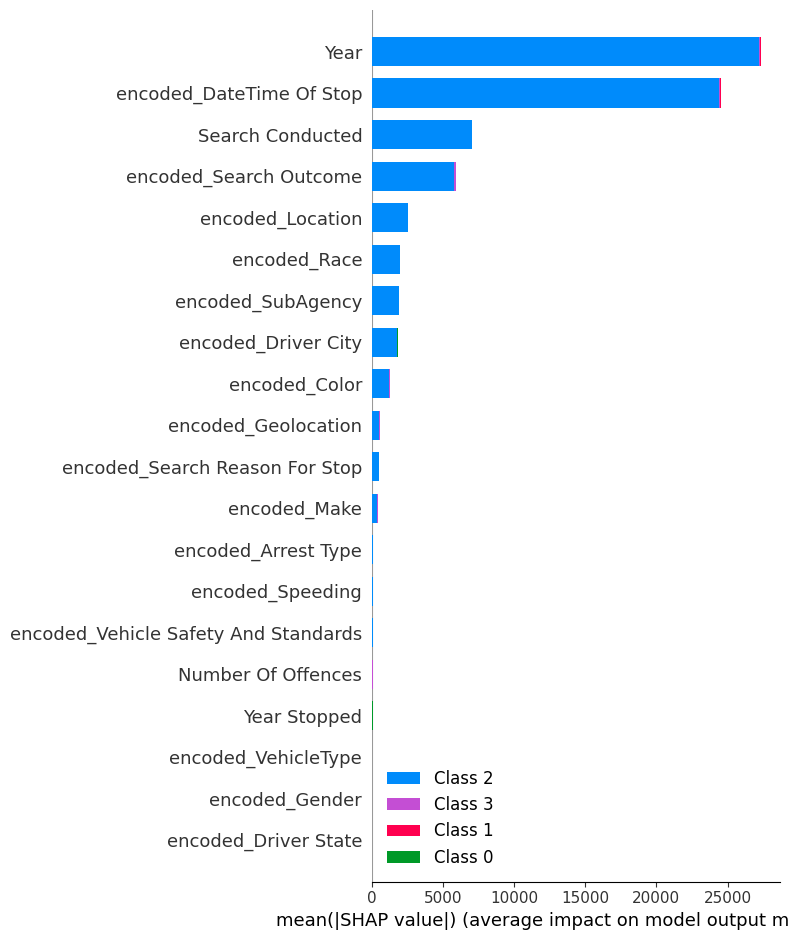

In [ ]:
shap.summary_plot(shap_values,X_test)

In [ ]:
shap_values = shap.TreeExplainer(model_lgbm).shap_values(X_test)

**Set up plots per label to show shap values per label class**

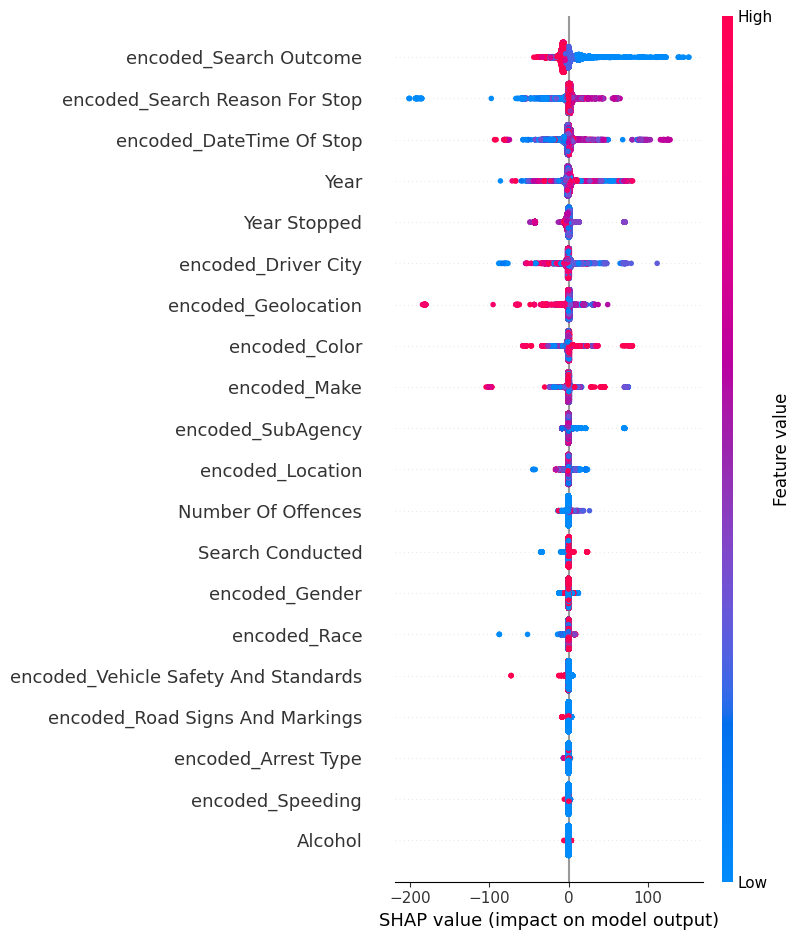

In [ ]:
shap.summary_plot(shap_values[0], X_test)

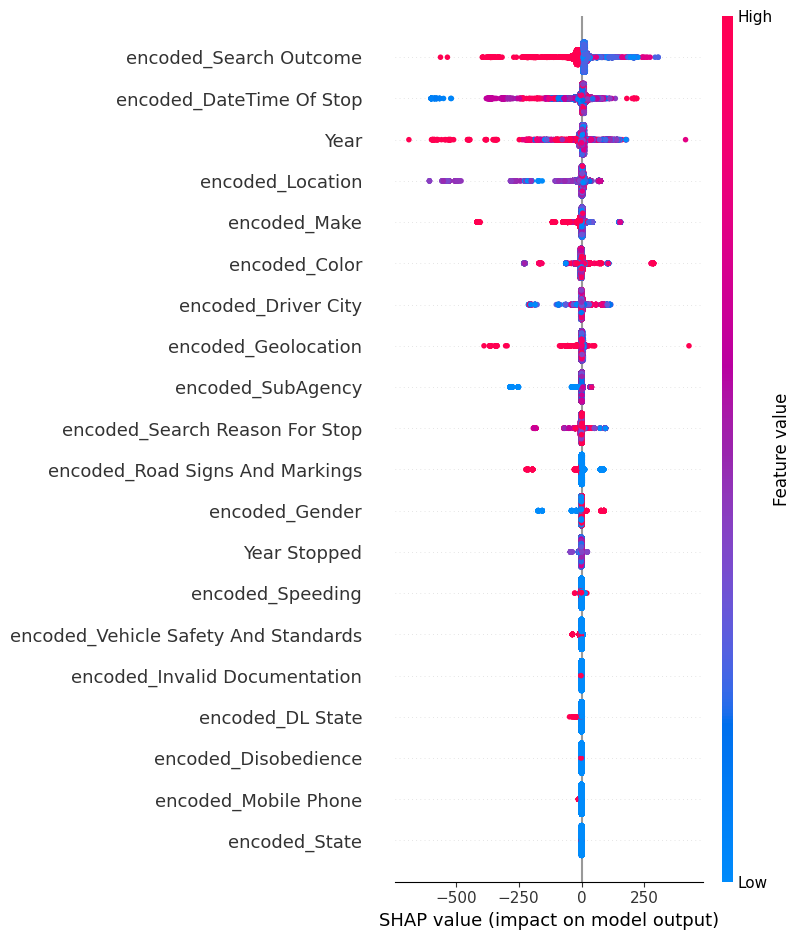

In [ ]:
shap.summary_plot(shap_values[1], X_test)

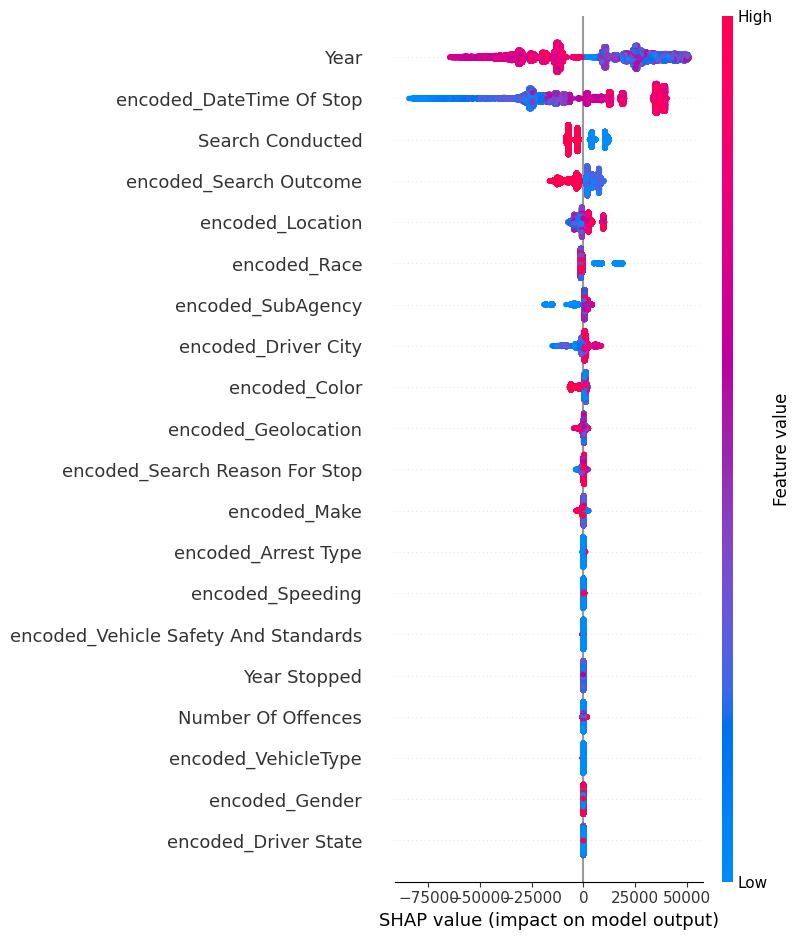

In [ ]:
shap.summary_plot(shap_values[2], X_test)

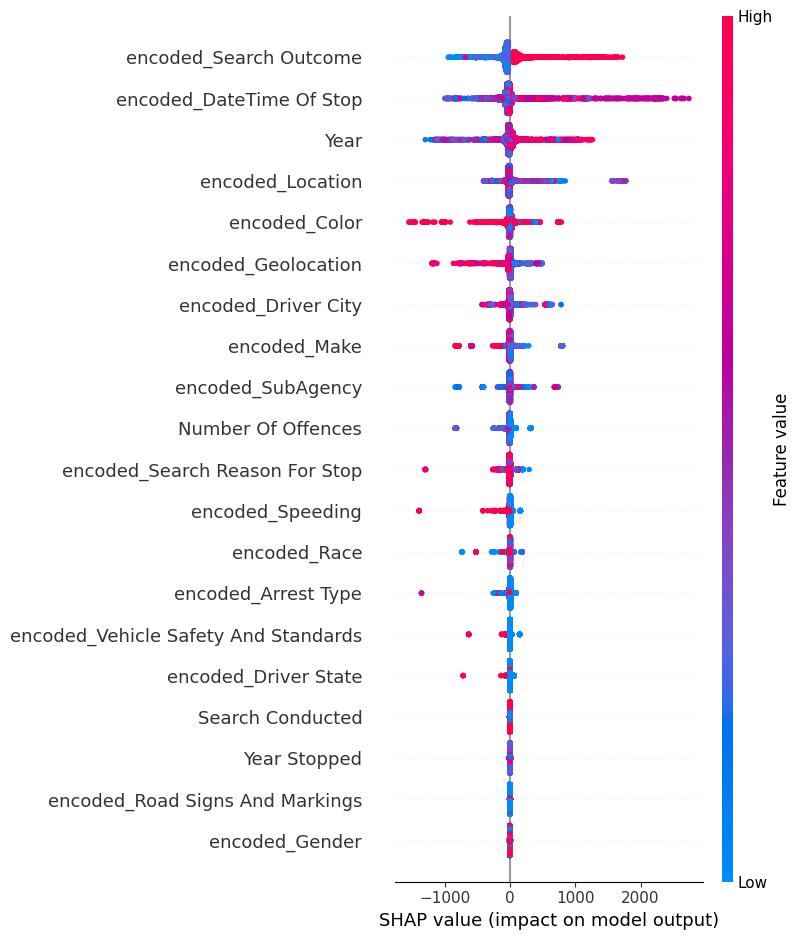

In [ ]:
shap.summary_plot(shap_values[3], X_test)